In [10]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Append the parent directory to the Python path^
sys.path.append(os.path.abspath(".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter
from scripts.gradient_descent import CustomLinearRegression



from scripts.evaluation import (
    evaluate_model,
    compare_models,
    cMSE_error
)
from scripts.models import (
    create_KNN_model,
    create_polynomial_model,
    cross_val_knn,
    cross_val_polynomial,
    evaluate_knn_imputation,
    run_imputation_baseline_model
)
from scripts.plots import (
    plot_best_degrees,
    plot_feature_complexity,
    plot_mse_metric_weight,
    plot_mse_per_degree,
    plot_y_yhat
)
from scripts.utils import (
    create_submission_csv,
    load_kaggle_df,
    load_model,
    load_starting_df,
    load_train_test,
    missing_columns,
    X_cols_universal, 
    y_cols_universal, 
    save_model
)

# Load data
startingDF = load_starting_df()
kaggleDF = load_kaggle_df()
kf = KFold(n_splits=10, shuffle=True)


# Task 2 - Nonlinear models

## Task 2.1 - Development

In [12]:
X_train, X_test, y_train, y_test = load_train_test()
X_train_reduced = X_train.drop(columns=missing_columns)
X_test_reduced = X_test.drop(columns=missing_columns)

X_train_reduced = X_train_reduced[y_train["SurvivalTime"].notna()]
y_train_reduced = y_train[y_train["SurvivalTime"].notna()]

X_test_reduced = X_test_reduced[y_test["SurvivalTime"].notna()]
y_test_reduced = y_test[y_test["SurvivalTime"].notna()]

kaggleDF_clean = kaggleDF.drop(columns=missing_columns)

In [13]:
# Number of NaN's in y_train and y_test
num_nan_y_train = y_train_reduced['SurvivalTime'].isna().sum()
num_nan_y_test = y_test_reduced['SurvivalTime'].isna().sum()

# Number of censored rows in y_train and y_test
num_censored_y_train = y_train_reduced['Censored'].sum()
num_censored_y_test = y_test_reduced['Censored'].sum()

print(f"Number of NaN's in y_train: {num_nan_y_train}")
print(f"Number of NaN's in y_test: {num_nan_y_test}")
print(f"Number of censored rows in y_train: {num_censored_y_train}")
print(f"Number of censored rows in y_test: {num_censored_y_test}")

Number of NaN's in y_train: 0
Number of NaN's in y_test: 0
Number of censored rows in y_train: 71
Number of censored rows in y_test: 8


### Polynomial Regression

#### Hyperparameter Tunning - GridSearchCV

In [14]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # PolynomialFeatures step
    ('model', LinearRegression())   # Linear regression model
])

# Define the hyperparameters for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_reduced, y_train_reduced["SurvivalTime"])

# Print the best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test_reduced)

# Evaluate performance
mse = mean_squared_error(y_test_reduced["SurvivalTime"], y_pred)
print(f"Mean Squared Error: {mse}")

Best parameters: {'poly__degree': 1}
Mean Squared Error: 3.2871238535117824


#### Hyperparameter Tunning - A la mão

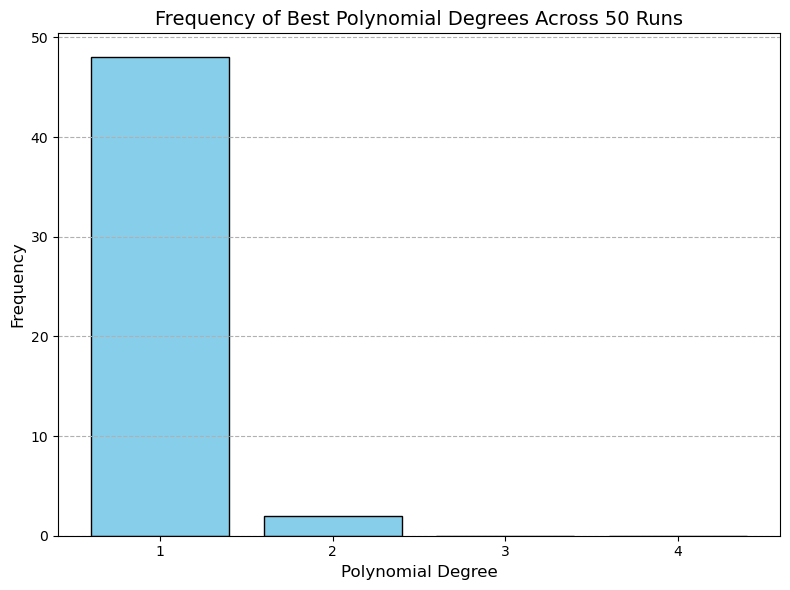

In [15]:
degrees = range(1, 5)
best_degrees = []
nRuns = 50

for run in range(nRuns):
    best_degree, _, _, _= cross_val_polynomial(X_train_reduced, y_train_reduced, degrees, k=10, printInfo=False)
    best_degrees.append(best_degree)

plot_best_degrees(best_degrees, degrees, nRuns)

In [16]:
best_degree, train_errors, val_errors, feature_counts = cross_val_polynomial(X_train_reduced, y_train_reduced, degrees, k=10)

Degree: 1, Feature Complexity (Number of Features): 5
Degree: 1, Average Training MSE: 3.800515934567202
Degree: 1, Average Validation MSE: 3.970695538612749

Degree: 2, Feature Complexity (Number of Features): 15
Degree: 2, Average Training MSE: 3.564735467055317
Degree: 2, Average Validation MSE: 4.208702640516157

Degree: 3, Feature Complexity (Number of Features): 35
Degree: 3, Average Training MSE: 3.385466230600737
Degree: 3, Average Validation MSE: 4.783940765142868

Degree: 4, Feature Complexity (Number of Features): 70
Degree: 4, Average Training MSE: 6.478716110144157
Degree: 4, Average Validation MSE: 10.852041255136228


Best Degree: 1 with Average Validation MSE: 3.970695538612749
Feature Complexity for Best Degree: 5 features


In [17]:
best_model_poly = create_polynomial_model(X_train_reduced, y_train_reduced["SurvivalTime"], degree=best_degree)
save_model(best_model_poly, "poly_reduced_features")
y_pred_poly = best_model_poly.predict(X_test_reduced)
cMSE_poly = cMSE_error(y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"])
print(f"cMSE (equivalent to MSE for non-censored data): {cMSE_poly}")

cMSE (equivalent to MSE for non-censored data): 3.020622295998217


In [18]:
# Filter out rows where Censored is 1
X_test_no_censored = X_test_reduced[y_test_reduced["Censored"] == 0]
y_test_no_censored = y_test_reduced[y_test_reduced["Censored"] == 0]

In [19]:
# Compare all
y_pred_baseline = load_model("baseline_reduced_features").predict(X_test_no_censored)
y_pred_poly = load_model("poly_reduced_features").predict(X_test_reduced)
y_pred_GD = load_model("Gradient_Descent_model").predict(X_test_reduced)

df = compare_models([("Polynomal Regression", y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"]), ("Gradient Descent", y_test_reduced["SurvivalTime"], y_pred_GD, y_test_reduced["Censored"]),  ("Baseline Model", y_test_no_censored["SurvivalTime"], y_pred_baseline,  y_test_no_censored["Censored"])])
df.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Polynomal Regression,4.536992,0.003830,1.387678,1.812420,3.020622
Gradient Descent,4.423167,0.035763,1.589872,1.919543,3.436626
Baseline Model,4.961072,0.171241,1.544248,2.107924,4.445811


In [20]:
# Kaggle Submission
create_submission_csv(best_model_poly.predict(kaggleDF_clean), "polynomial_submission_01.csv")

CSV file 'polynomial_submission_01.csv' has been created.


#### Plots for Polynomial Regression

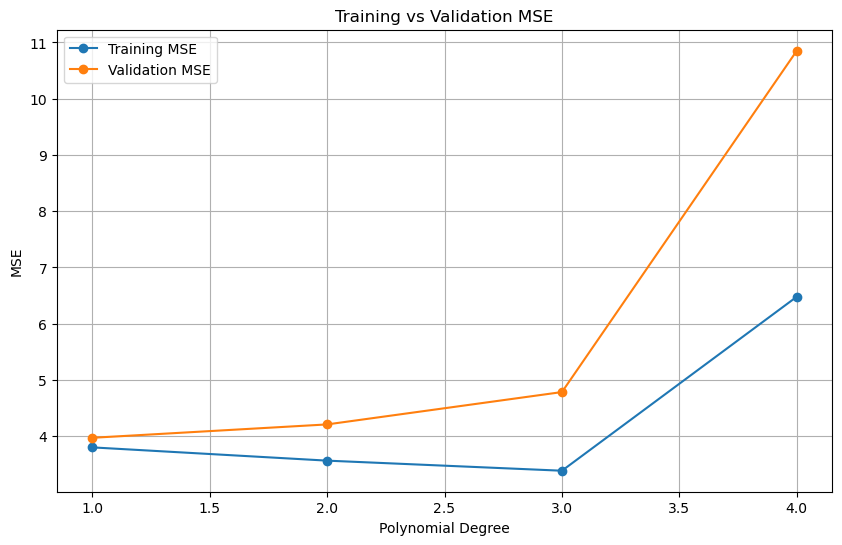

In [21]:
plot_mse_per_degree(train_errors, val_errors)

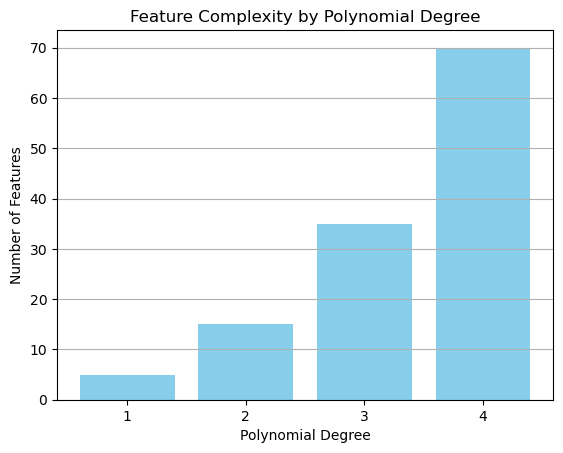

In [22]:
plot_feature_complexity(feature_counts, val_errors)

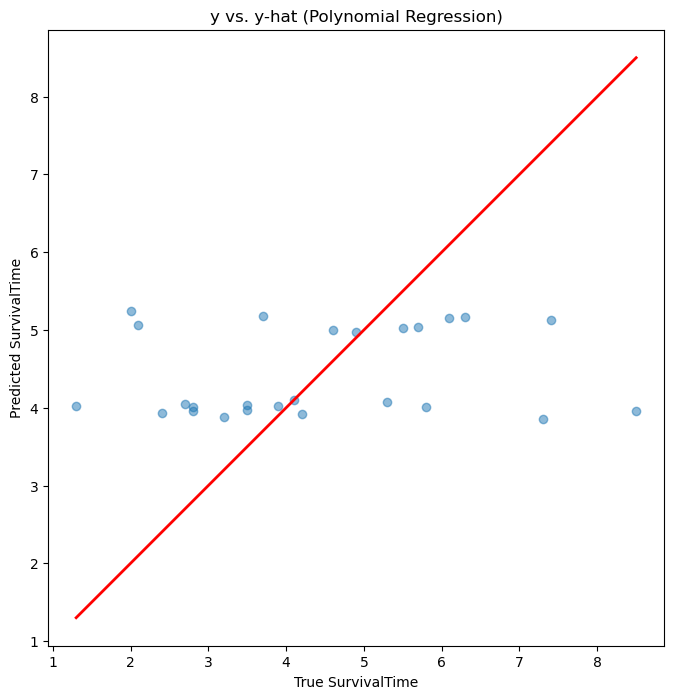

In [23]:
plot_y_yhat(y_test_reduced["SurvivalTime"], y_pred_poly, plot_title="y vs. y-hat (Polynomial Regression)")

### KNN Regression

In [24]:
KValues = range(1, 51)
metrics = ['euclidean', 'manhattan']
weights = ['uniform', 'distance']

##### Hyper Tuning using GridSearchCV

In [25]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],           # Number of neighbors
    'weights': ['uniform', 'distance'],        # Weight function
    'metric': ['euclidean', 'manhattan'],     # Distance metrics
}

grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error')

grid_search.fit(X_train_reduced, y_train_reduced["SurvivalTime"])

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best Cross-Validation Score: -4.35731834281421


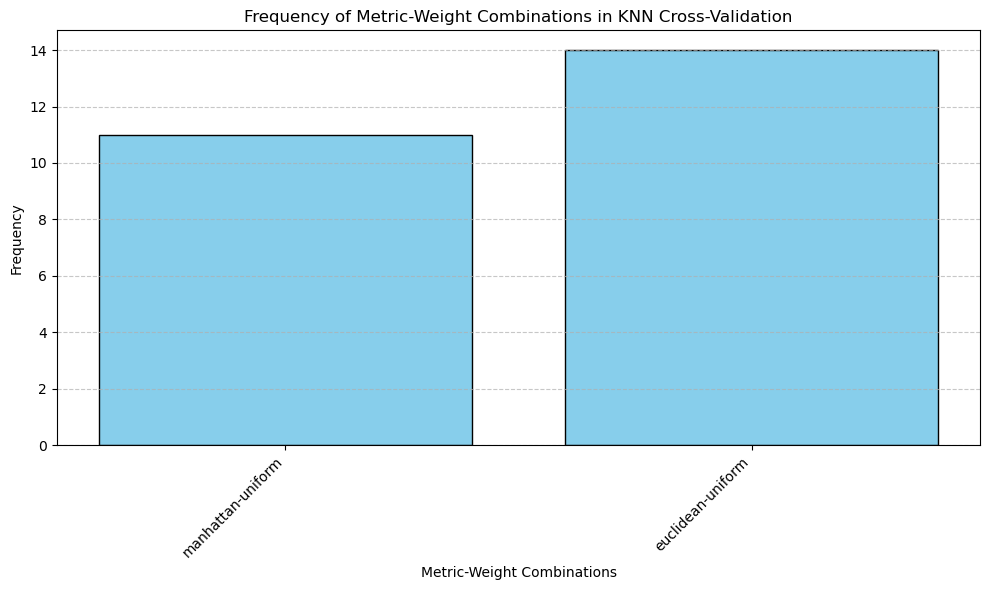

In [26]:
runs = 25
combinations = []

# Run cross_val_knn 50 times
for _ in range(runs):
    best_params, _, _, _, _ = cross_val_knn(X_train_reduced, y_train_reduced,KValues, weights, metrics, k=10, printInfo=False)
    combinations.append((best_params[1], best_params[2]))  # Collect metric and weight combinations

# Count the frequency of each combination
combination_counts = Counter(combinations)

# Prepare data for the histogram
labels, frequencies = zip(*combination_counts.items())

# Convert tuples of labels into readable strings
labels_str = [f"{metric}-{weight}" for metric, weight in labels]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(labels_str, frequencies, color="skyblue", edgecolor="black")
plt.xlabel("Metric-Weight Combinations")
plt.ylabel("Frequency")
plt.title("Frequency of Metric-Weight Combinations in KNN Cross-Validation")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
best_params, train_errors, val_errors, cv_results, metric_weight_mse = cross_val_knn(X_train_reduced, y_train_reduced,KValues, weights, metrics, k=10, printInfo=True)

k: 1, Metric: euclidean, Weights: uniform, Average Validation MSE: 7.60469264069264
k: 1, Metric: manhattan, Weights: uniform, Average Validation MSE: 6.765558441558442
k: 1, Metric: euclidean, Weights: distance, Average Validation MSE: 7.282945887445886
k: 1, Metric: manhattan, Weights: distance, Average Validation MSE: 7.652374458874459
k: 2, Metric: euclidean, Weights: uniform, Average Validation MSE: 5.568370670995671
k: 2, Metric: manhattan, Weights: uniform, Average Validation MSE: 5.747215367965368
k: 2, Metric: euclidean, Weights: distance, Average Validation MSE: 6.4204544690766046
k: 2, Metric: manhattan, Weights: distance, Average Validation MSE: 5.943885934056932
k: 3, Metric: euclidean, Weights: uniform, Average Validation MSE: 5.04010076960077
k: 3, Metric: manhattan, Weights: uniform, Average Validation MSE: 4.835188071188071
k: 3, Metric: euclidean, Weights: distance, Average Validation MSE: 5.91645197746667
k: 3, Metric: manhattan, Weights: distance, Average Validation

In [28]:
print(f"Best Parameters: k={best_params[0]}, Metric={best_params[1]}, Weights={best_params[2]}")
best_kNN_model = create_KNN_model(X_train_reduced, y_train_reduced["SurvivalTime"], best_params[0], best_params[1], best_params[2])
save_model(best_kNN_model, "knn_reduced_features")
y_pred_kNN = best_kNN_model.predict(X_test_reduced)
cMSE_kNN = cMSE_error(y_test_reduced["SurvivalTime"], y_pred_kNN, y_test_reduced["Censored"])
print(f"cMSE: {cMSE_kNN}")

Best Parameters: k=22, Metric=euclidean, Weights=uniform
cMSE: 3.016535537190082


In [29]:
y_pred_baseline = load_model("baseline_reduced_features").predict(X_test_no_censored)
y_pred_poly = load_model("poly_reduced_features").predict(X_test_reduced)

df = compare_models([("Polynomal Regression", y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"]), ("Gradient Descent", y_test_reduced["SurvivalTime"], y_pred_GD, y_test_reduced["Censored"]),  ("Baseline Model", y_test_no_censored["SurvivalTime"], y_pred_baseline,  y_test_no_censored["Censored"]), ("KNN (k = 20)", y_test_reduced["SurvivalTime"], y_pred_kNN, y_test_reduced["Censored"])])
df.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Polynomal Regression,4.536992,0.003830,1.387678,1.812420,3.020622
Gradient Descent,4.423167,0.035763,1.589872,1.919543,3.436626
Baseline Model,4.961072,0.171241,1.544248,2.107924,4.445811
KNN (k = 20),5.013636,0.172727,1.363455,1.806297,3.016536


In [30]:
# Kaggle Submission
create_submission_csv(best_kNN_model.predict(kaggleDF_clean), "knn_submission_03.csv")

CSV file 'knn_submission_03.csv' has been created.


Plots for kNN model

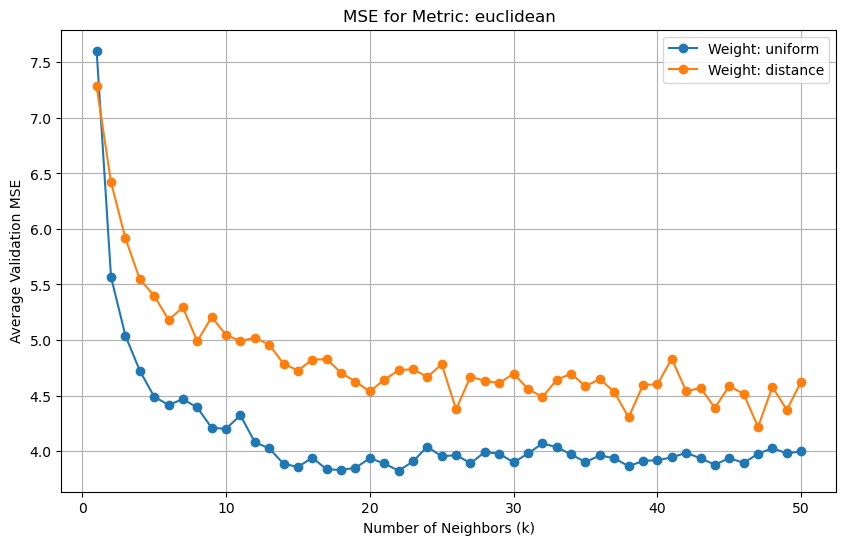

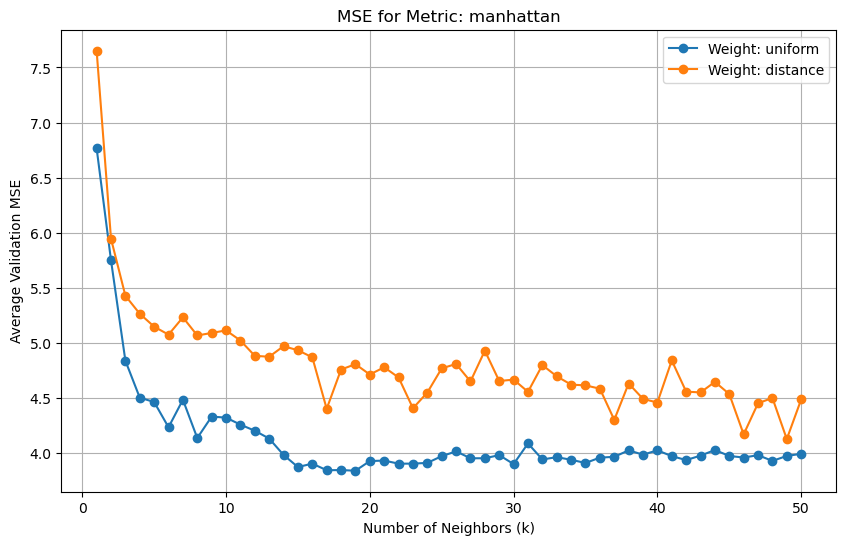

In [31]:
plot_mse_metric_weight(KValues, metric_weight_mse)

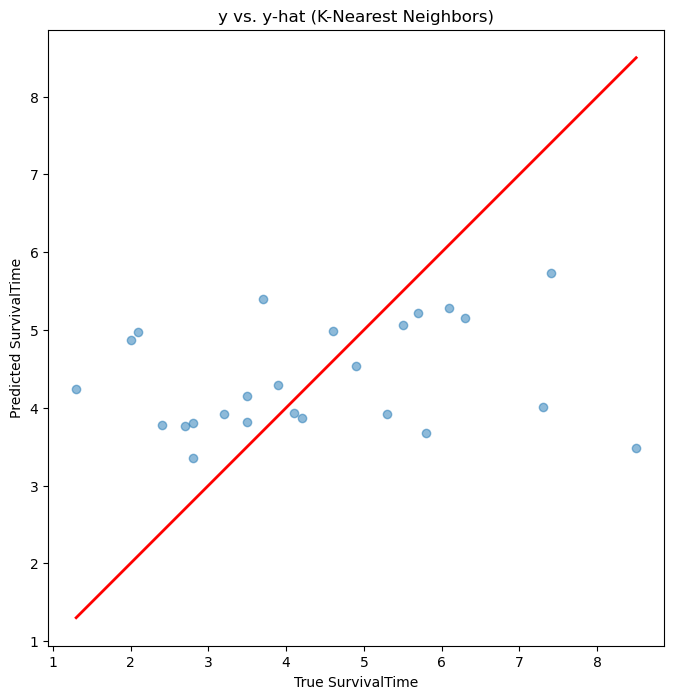

In [32]:
plot_y_yhat(y_test_reduced["SurvivalTime"], y_pred_kNN, plot_title="y vs. y-hat (K-Nearest Neighbors)")

### Task 2.2 - Evaluation

In [33]:
# Chega certo ? Yes, it does. Estou a assumir que desenvolvemos mais no relatório
df.T.sort_values(by="cMSE")

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
KNN (k = 20),5.013636,0.172727,1.363455,1.806297,3.016536
Polynomal Regression,4.536992,0.003830,1.387678,1.812420,3.020622
Gradient Descent,4.423167,0.035763,1.589872,1.919543,3.436626
Baseline Model,4.961072,0.171241,1.544248,2.107924,4.445811


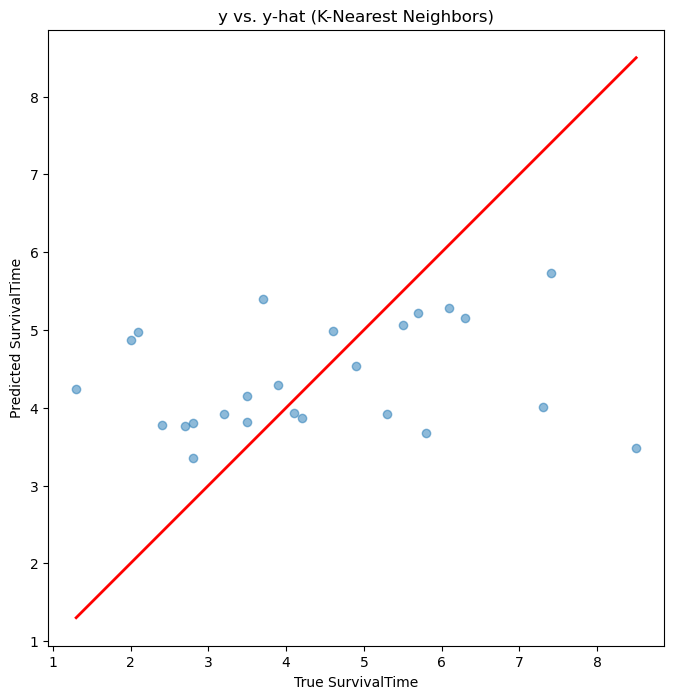

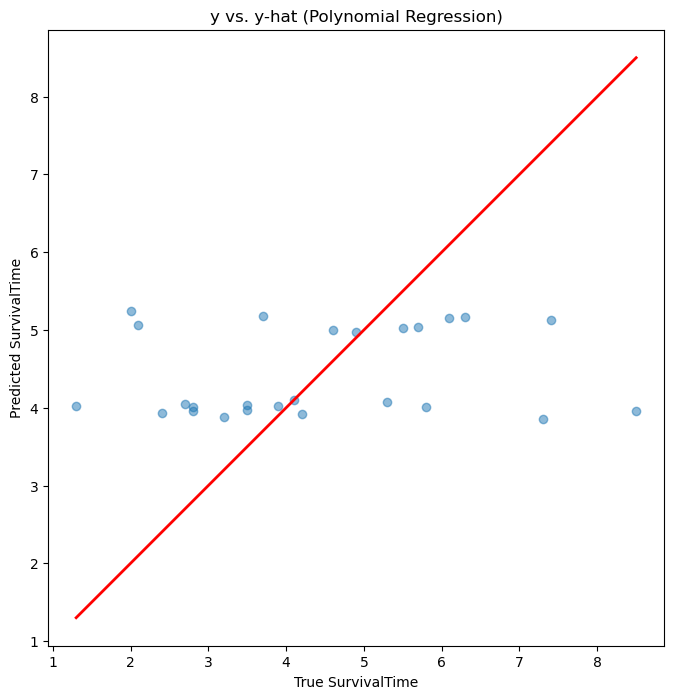

In [34]:
plot_y_yhat(y_test_reduced["SurvivalTime"], y_pred_kNN, plot_title="y vs. y-hat (K-Nearest Neighbors)")
plot_y_yhat(y_test_reduced["SurvivalTime"], y_pred_poly, plot_title="y vs. y-hat (Polynomial Regression)")